In [547]:
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

DATA_DIR = "data/"

In [731]:
read = lambda file: pd.read_csv(DATA_DIR + file, parse_dates=["date"])

train = read("train.csv")
test = read("test.csv")
oil = read("oil.csv")
trans = read("transactions.csv")
hol = read("holidays_events.csv")
stores = pd.read_csv(DATA_DIR + "stores.csv")

train["y"] = np.log1p(train.sales)

# add trend terms

all_dates = set(train.date).union(set(test.date))
date_idx = {date: i for i, date in enumerate(sorted(all_dates))}

train["trend"] = train.date.map(date_idx)
test["trend"] = test.date.map(date_idx)

for df in (train, test):
    df["month"] = df.date.apply(lambda x: x.month)
    df["dow"] = df.date.apply(lambda x: x.weekday())

# create validation set

val_periods = 16
val_trend_cutoff = train.trend.max() - val_periods
val = train.loc[train.trend > val_trend_cutoff].copy()

In [676]:
# see what store sells what:

nonzero_sales = (
    train
    .groupby(["store_nbr", "family"])
    .apply(lambda grp: np.mean(grp.sales > 5))
    .reset_index()
    .rename(columns={0: "nonzero_prop"})
    .pivot(index="store_nbr", columns="family")
)

nonzero_sales

nonzero_prop                                                       \
family      AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES     BOOKS BREAD/BAKERY   
store_nbr                                                                     
1             0.166271  0.000000  0.067102  0.996437  0.001781     0.996437   
2             0.428741  0.000000  0.332542  0.997031  0.001781     0.997031   
3             0.755344  0.008314  0.713777  0.997031  0.016033     0.997031   
4             0.249406  0.000000  0.259501  0.997031  0.001781     0.997031   
5             0.425772  0.000000  0.387767  0.997031  0.001188     0.997031   
6             0.391330  0.000000  0.426960  0.997031  0.001188     0.997031   
7             0.272565  0.000000  0.188836  0.997031  0.005938     0.997031   
8             0.393705  0.000000  0.594418  0.997031  0.004751     0.997031   
9             0.893112  0.000594  0.405582  0.997031  0.000000     0.997031   
10            0.138955  0.011283  0.014846  0.997031  0.000000     0.997031   
11            0.546318  0.000594  0.326603  0.997031  0.000000     0.997031   
12            0.345606  0.000000  0.006532  0.961401  0.000000     0.961401   
13            0.438836  0.000000  0.014252  0.997031  0.000000     0.997031   
14            0.213777  0.000000  0.024941  0.974466  0.000000     0.974466   
15            0.113420  0.023753  0.042755  0.997031  0.000000     0.997031   
16            0.454276  0.000000  0.005938  0.997031  0.000000     0.997031   
17            0.470903  0.001781  0.060570  0.995843  0.000000     0.995843   
18            0.250594  0.000000  0.065321  0.931116  0.000000     0.931710   
19            0.526128  0.000000  0.027910  0.997031  0.000000     0.997031   
20            0.351544  0.002375  0.202494  0.540974  0.000000     0.540974   
21            0.362827  0.003563  0.159145  0.445368  0.000000     0.445368   
22            0.155582  0.000000  0.013658  0.399644  0.000000     0.399644   
23            0.064727  0.000000  0.026722  0.997031  0.000000     0.997031   
24            0.160926  0.000000  0.382423  0.937055  0.001188     0.937055   
25            0.077197  0.000000  0.087292  0.960808  0.000594     0.960808   
26            0.208432  0.001188  0.005938  0.997031  0.000000     0.997031   
27            0.352138  0.000000  0.208432  0.997031  0.000000     0.997031   
28            0.577791  0.000000  0.067102  0.997031  0.000000     0.997031   
29            0.269002  0.002375  0.071259  0.520190  0.000000     0.520190   
30            0.147268  0.000000  0.001781  0.983373  0.000000     0.982779   
31            0.634798  0.022565  0.100950  0.997031  0.000000     0.997031   
32            0.052257  0.000594  0.000000  0.997031  0.000000     0.997031   
33            0.635392  0.001188  0.011283  0.997031  0.000000     0.997031   
34            0.171021  0.001188  0.111045  0.997031  0.000000     0.997031   
35            0.295724  0.000594  0.000000  0.997031  0.000000     0.997031   
36            0.236936  0.000594  0.026128  0.922209  0.000000     0.922209   
37            0.235154  0.000000  0.278504  0.997031  0.005938     0.997031   
38            0.513658  0.000594  0.359264  0.997031  0.001188     0.997031   
39            0.702494  0.001781  0.229810  0.997031  0.000000     0.997031   
40            0.231591  0.004157  0.014252  0.997031  0.000000     0.997031   
41            0.350356  0.000000  0.286223  0.997031  0.000000     0.997031   
42            0.105107  0.000000  0.184679  0.428741  0.005938     0.428741   
43            0.465558  0.000000  0.026128  0.994656  0.000000     0.994062   
44            0.956651  0.000000  0.785036  0.997031  0.011283     0.997031   
45            0.942399  0.000000  0.752969  0.997031  0.013658     0.997031   
46            0.923397  0.000000  0.818290  0.997031  0.002969     0.997031   
47            0.945368  0.000000  0.833729  0.997031  0.017221     0.997031   
48            0.865796  0.000000  0.738124  0.997031  0.0000

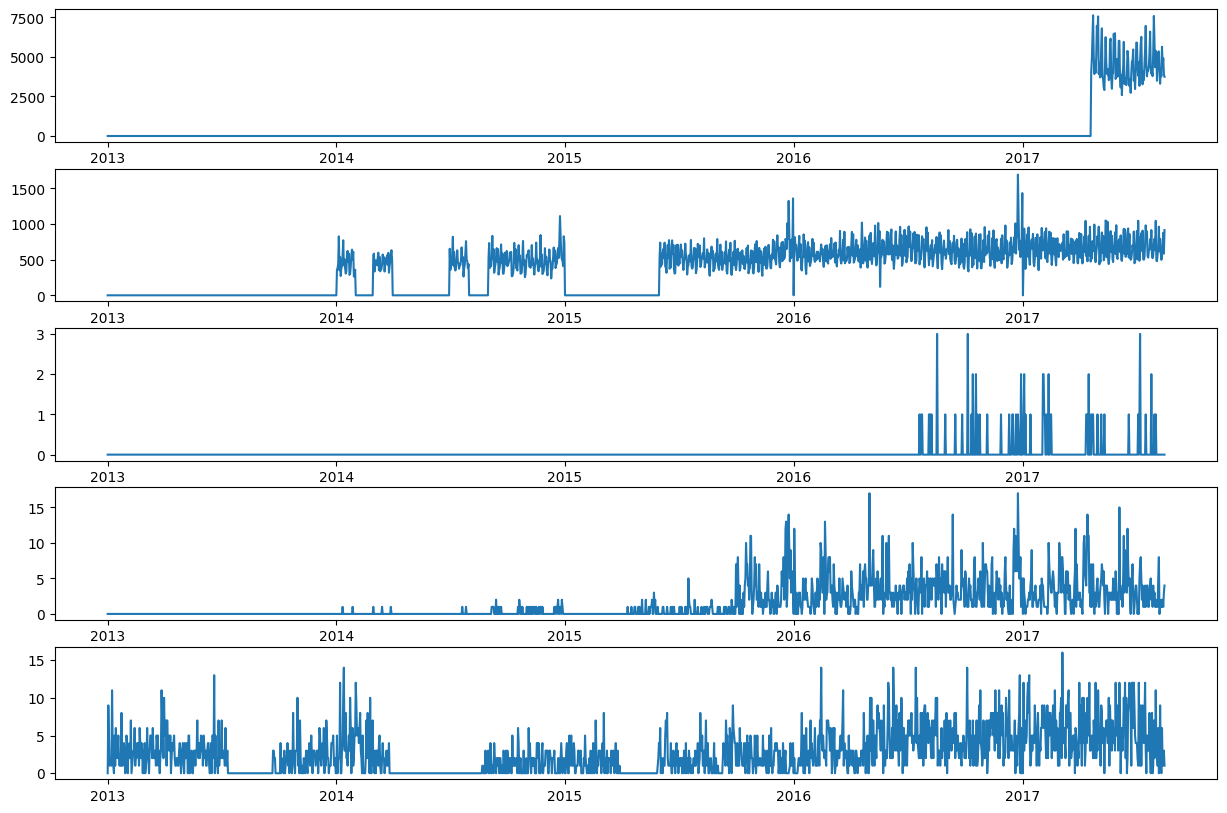

In [677]:
fig, ax = plt.subplots(nrows=5, figsize=(15, 10))
ax[0].plot("date", "sales", data=train.query("store_nbr == 52 and family == 'BEVERAGES'"))
ax[1].plot("date", "sales", data=train.query("store_nbr == 54 and family == 'PRODUCE'"))
ax[2].plot("date", "sales", data=train.query("store_nbr == 24 and family == 'BABY CARE'"))
ax[3].plot("date", "sales", data=train.query("store_nbr == 11 and family == 'MAGAZINES'"))
ax[4].plot("date", "sales", data=train.query("store_nbr == 12 and family == 'SEAFOOD'"))
plt.show()

In [732]:
GRP = ["store_nbr", "family"]

get_groups = lambda df: set(df[GRP].drop_duplicates().apply(lambda row: (row[0], row[1]), axis=1))

GROUPS = get_groups(train)

In [733]:
# subset out the "flat spots" where the product family is not sold in the store for a prolonged period of time
# these will make it hard to forecast the series
# find flat spots

MIN_LEN = 7 # this many zeros in a row constitutes a flat spot

FLAT = []

for (store, fam), grp_df in train.groupby(GRP):
    in_zero = False
    for row in grp_df.itertuples():
        if row.sales == 0 and not in_zero:
            start = row.trend
            in_zero = True
        elif row.sales > 0 and in_zero:
            end = row.trend - 1
            in_zero = False
            if end - start >= MIN_LEN:
                FLAT.append({"store_nbr": store, "family": fam, "start": start, "end": end})
    
    if in_zero and row.trend - start + 1 >= MIN_LEN:
        FLAT.append({"store_nbr": store, "family": fam, "start": start, "end": row.trend})

In [734]:
# subset training data to points after the last "flat spot"

F = pd.DataFrame(FLAT)
last_flat = F.groupby(GRP).end.max().reset_index()

train_cont = (
    train
    .merge(last_flat, on=GRP, how="left")
    .query("end.isnull() or trend > end")
    .drop("end", axis=1)
)
train_cont.index = range(train_cont.shape[0])

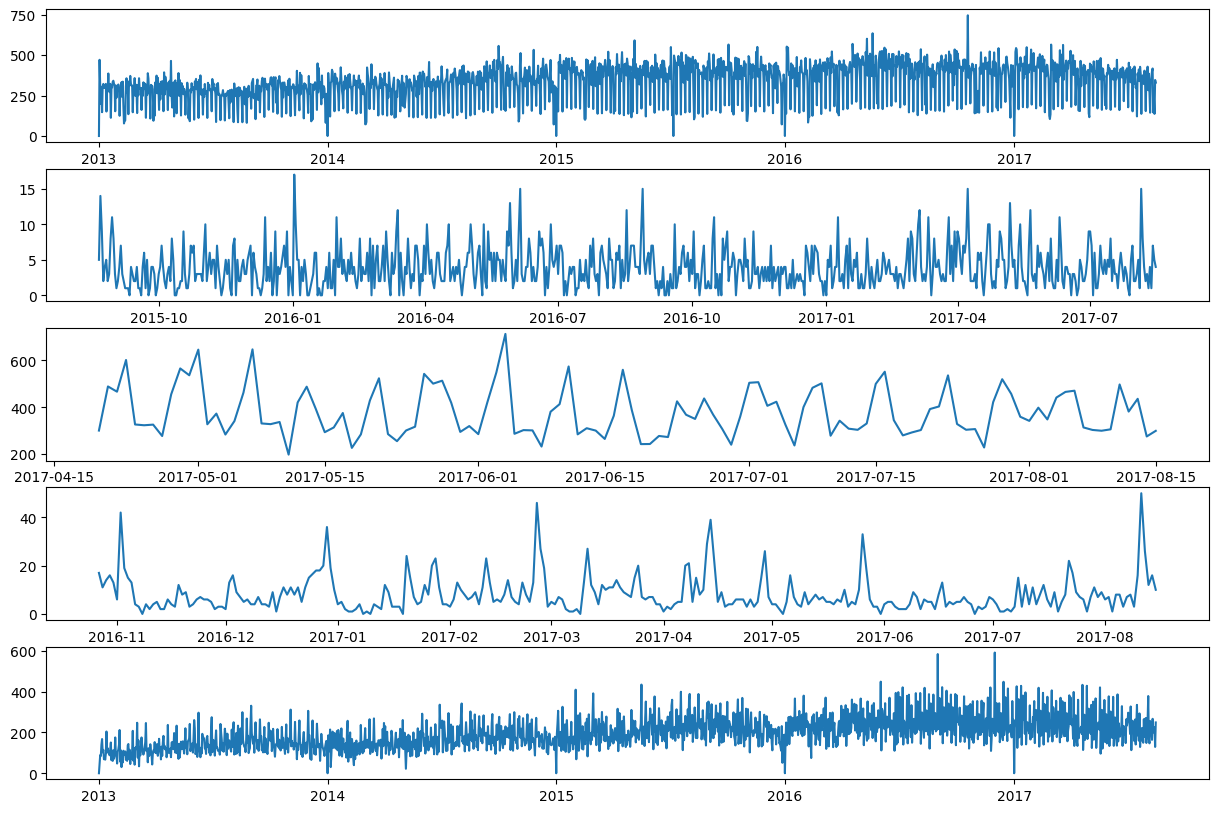

In [735]:
# all data in the training dataframe should now be continuous
# check a few:

fig, ax = plt.subplots(nrows=5, figsize=(15, 10))
ax[0].plot("date", "sales", data=cont.query("store_nbr == 1 and family == 'BREAD/BAKERY'"))
ax[1].plot("date", "sales", data=cont.query("store_nbr == 42 and family == 'AUTOMOTIVE'"))
ax[2].plot("date", "sales", data=cont.query("store_nbr == 52 and family == 'DELI'"))
ax[3].plot("date", "sales", data=cont.query("store_nbr == 25 and family == 'MAGAZINES'"))
ax[4].plot("date", "sales", data=cont.query("store_nbr == 28 and family == 'MEATS'"))
plt.show()

In [736]:
# get groups that ended with a zero spot
# these will receive a zero prediction

CONT_GROUPS = get_groups(train_cont)
ZERO_GROUPS = GROUPS.difference(CONT_GROUPS)

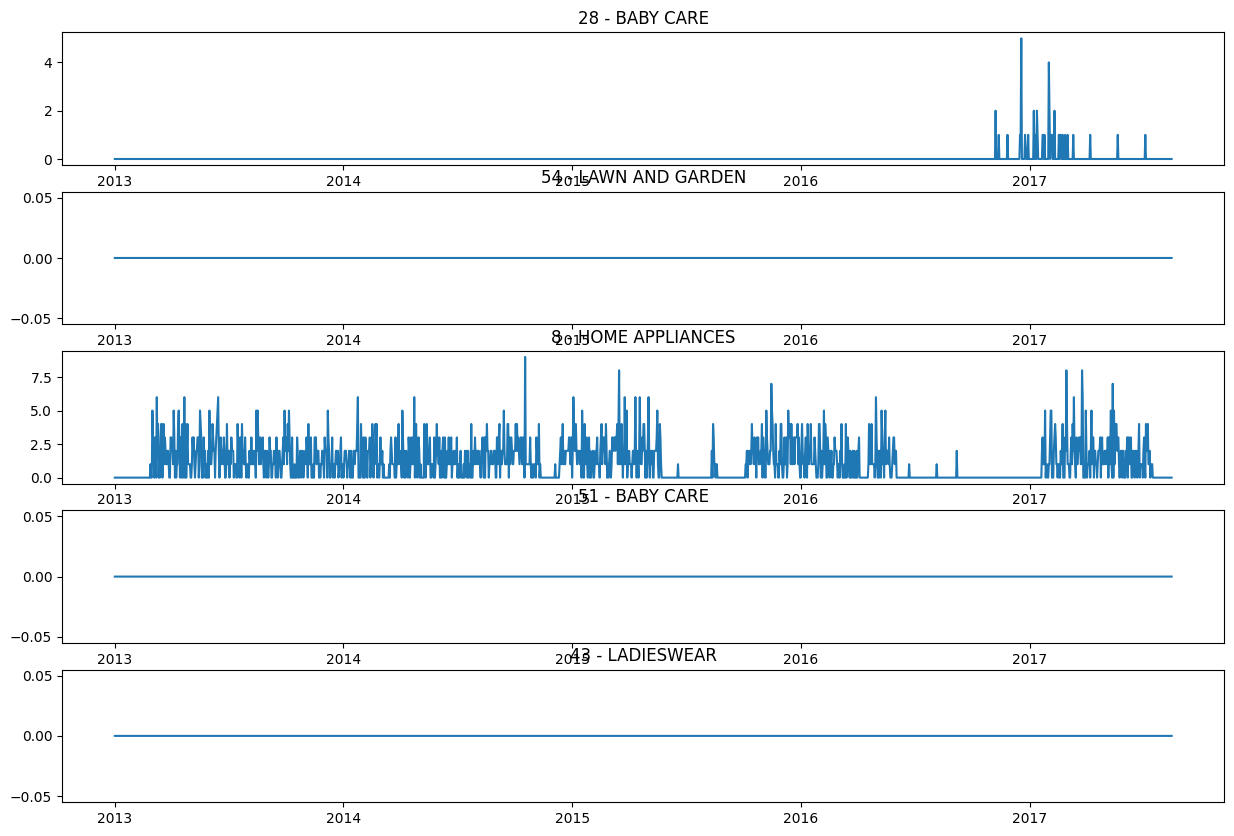

In [737]:
# plot a few:

fig, ax = plt.subplots(nrows=5, figsize=(15, 10))

for i, (s, f) in enumerate(random.sample(list(ZERO_GROUPS), 5)):
    ax[i].plot("date", "sales", data=train.query(f"store_nbr == {s} and family == '{f}'"))
    ax[i].set_title(f"{s} - {f}")
    
plt.show()

## Baseline: linear regression

In [738]:
train_sub = train_cont[train_cont.trend <= val_trend_cutoff]


def append_indicators(train_df, test_df, col):
    enc = OneHotEncoder(sparse=False)

    train_vals = train_df[col].values.reshape(-1, 1)
    test_vals = test_df[col].values.reshape(-1, 1)
    
    train_inds = enc.fit_transform(train_vals)
    test_inds = enc.transform(test_vals)
    
    col_names = [f"{col}_{cat}" for cat in enc.categories_[0]]
    
    train_ind_df = pd.DataFrame(train_inds, index=train_df.index, columns=col_names).astype(np.uint8)
    train_out = pd.concat((train_df, train_ind_df), axis=1)
    
    test_ind_df = pd.DataFrame(test_inds, index=test_df.index, columns=col_names).astype(np.uint8)
    test_out = pd.concat((test_df, test_ind_df), axis=1)
    
    return train_out, test_out

lin_train, lin_val = append_indicators(train_sub, val, "month")
lin_train, lin_val = append_indicators(lin_train, lin_val, "dow")

In [741]:
lin_train

,id,date,store_nbr,family,sales,onpromotion,y,trend,month,dow,...,month_10,month_11,month_12,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.000000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,2,2013-01-01,1,BEAUTY,0.000,0,0.000000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,3,2013-01-01,1,BEVERAGES,0.000,0,0.000000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,5,2013-01-01,1,BREAD/BAKERY,0.000,0,0.000000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
4,7,2013-01-01,1,CLEANING,0.000,0,0.000000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819091,2972371,2017-07-30,9,POULTRY,517.911,1,6.251732,1667,7,6,...,0,0,0,0,0,0,0,0,0,1
1819092,2972372,2017-07-30,9,PREPARED FOODS,145.490,1,4.986957,1667,7,6,...,0,0,0,0,0,0,0,0,0,1
1819093,2972373,2017-07-30,9,PRODUCE,1882.588,7,7.540934,1667,7,6,...,0,0,0,0,0,0,0,0,0,1
1819094,2972374,2017-07-30,9,SCHOOL AND OFFICE SUPPLIES,41.000,8,3.737670,1667,7,6,...,0,0,0,0,0,0,0,0,0,1


In [744]:
val_preds = {}

incl_re = re.compile(r"^(?:trend|month_|dow_)")
pred_cols = [col for col in train_grp.columns if incl_re.search(col) is not None]

for (store, family), train_grp in lin_train.groupby(GRP):    
    val_grp = lin_val.query(f"store_nbr == {store} and family == '{family}'")
    
    X_train = train_grp[pred_cols].values
    X_val = val_grp[pred_cols].values
    
    y_train = train_grp.y
    y_val = val_grp.y
    
    mdl = LinearRegression()
    mdl.fit(X_train, y_train)
    
    preds = mdl.predict(X_val)
    sales_preds = np.expm1(preds)
    sales_preds[sales_preds < 0] = 0
    
    pred_dict = {_id: pred for (_id, pred) in zip(val_grp["id"], sales_preds)}
    val_preds.update(pred_dict)

In [745]:
val["sales_pred"] = val["id"].map(val_preds).fillna(0)

In [746]:
mean_squared_log_error(val.sales, val.sales_pred, squared=False)

0.570834919827023

In [706]:
len(m)

174

<AxesSubplot: >

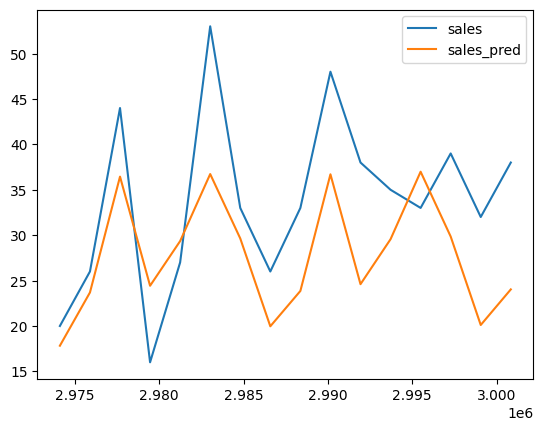

In [753]:
val.query("store_nbr == 8 and family == 'LAWN AND GARDEN'")[["sales", "sales_pred"]].plot()

In [754]:
s

,store_nbr,family,0
0,1,AUTOMOTIVE,0.524332
1,1,BABY CARE,0.000000
2,1,BEAUTY,0.434243
3,1,BEVERAGES,0.299928
4,1,BOOKS,0.173287
...,...,...,...
1777,54,POULTRY,0.201246
1778,54,PREPARED FOODS,0.252139
1779,54,PRODUCE,0.087618
1780,54,SCHOOL AND OFFICE SUPPLIES,0.000000


In [756]:
train_sub = train_cont


def append_indicators(train_df, test_df, col):
    enc = OneHotEncoder(sparse=False)

    train_vals = train_df[col].values.reshape(-1, 1)
    test_vals = test_df[col].values.reshape(-1, 1)
    
    train_inds = enc.fit_transform(train_vals)
    test_inds = enc.transform(test_vals)
    
    col_names = [f"{col}_{cat}" for cat in enc.categories_[0]]
    
    train_ind_df = pd.DataFrame(train_inds, index=train_df.index, columns=col_names).astype(np.uint8)
    train_out = pd.concat((train_df, train_ind_df), axis=1)
    
    test_ind_df = pd.DataFrame(test_inds, index=test_df.index, columns=col_names).astype(np.uint8)
    test_out = pd.concat((test_df, test_ind_df), axis=1)
    
    return train_out, test_out

lin_train, lin_test = append_indicators(train_sub, test, "month")
lin_train, lin_val = append_indicators(lin_train, lin_test, "dow")

In [758]:
val_preds = {}

incl_re = re.compile(r"^(?:trend|month_|dow_)")
pred_cols = [col for col in train_grp.columns if incl_re.search(col) is not None]

for (store, family), train_grp in lin_train.groupby(GRP):    
    val_grp = lin_val.query(f"store_nbr == {store} and family == '{family}'")
    
    X_train = train_grp[pred_cols].values
    X_val = val_grp[pred_cols].values
    
    y_train = train_grp.y
    
    mdl = LinearRegression()
    mdl.fit(X_train, y_train)
    
    preds = mdl.predict(X_val)
    sales_preds = np.expm1(preds)
    sales_preds[sales_preds < 0] = 0
    
    pred_dict = {_id: pred for (_id, pred) in zip(val_grp["id"], sales_preds)}
    val_preds.update(pred_dict)

In [760]:
test["sales_pred"] = test["id"].map(val_preds).fillna(0)

In [763]:
test[["id", "sales_pred"]].rename(columns={"sales_pred": "sales"}).to_csv("submission.csv", index=False)